## Imports
---

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import time
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, Linear
import torch_geometric.transforms as T
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.dataset import get_full_transactions_dataset 

2025-02-26 20:58:48.263 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-02-26 20:58:48.264 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-02-26 20:58:48.265 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
print(f"Using Torch version {torch.__version__}")
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}") 
cuda_id = torch.cuda.current_device()
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Using Torch version 2.5.1+cu124
Is CUDA supported by this system? True
CUDA version: 12.4
Name of current CUDA device:NVIDIA GeForce RTX 2060


## Data set load
---

In [3]:
df = get_full_transactions_dataset()

2025-02-26 20:58:48.286 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-02-26 20:58:48.287 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 20:58:48.699 
  command:

    streamlit run C:\Users\ferna\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-26 20:58:48.699 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 20:58:48.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 20:58:49.204 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 20:58:49.216 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 20:58:56.370 Thread 'Ma

## Data preparation
---

### Handling imbalanced data

In [4]:
df.head()

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,10_8000EBD30,10_8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208_8000F4580,1_8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209_8000F4670,3209_8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12_8000F5030,12_8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10_8000F5200,10_8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


### Preprocessing

In [5]:
label_encoder_columns = ["receiving_currency", "payment_currency", "payment_format"]
label_encoder = LabelEncoder()
for column in label_encoder_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df['timestamp'] = df['timestamp'].apply(lambda x: x.value)
df['timestamp'] = (df['timestamp']-df['timestamp'].min())/(df['timestamp'].max()-df['timestamp'].min())

In [7]:
df = df.sort_values(by="sender")

In [8]:
df.head()

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
4278714,0.456320,10057_803A115E0,29467_803E020C0,787197.11,13,787197.11,13,3,0
2798190,0.285018,10057_803A115E0,29467_803E020C0,787197.11,13,787197.11,13,3,0
2798191,0.284233,10057_803A115E0,29467_803E020C0,681262.19,13,681262.19,13,4,0
3918769,0.417079,10057_803A115E0,29467_803E020C0,681262.19,13,681262.19,13,4,0
213094,0.000746,10057_803A115E0,10057_803A115E0,146954.27,13,146954.27,13,5,0


In [9]:
scaler = MinMaxScaler()
df[['amount_received', 'amount_paid']] = scaler.fit_transform(df[['amount_received', 'amount_paid']])

In [10]:
df.head()

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
4278714,0.456320,10057_803A115E0,29467_803E020C0,7.523610e-07,13,7.523610e-07,13,3,0
2798190,0.285018,10057_803A115E0,29467_803E020C0,7.523610e-07,13,7.523610e-07,13,3,0
2798191,0.284233,10057_803A115E0,29467_803E020C0,6.511141e-07,13,6.511141e-07,13,4,0
3918769,0.417079,10057_803A115E0,29467_803E020C0,6.511141e-07,13,6.511141e-07,13,4,0
213094,0.000746,10057_803A115E0,10057_803A115E0,1.404511e-07,13,1.404511e-07,13,5,0


### Node features

In [11]:
all_account_ids = set(df['sender']).union(set(df['receiver']))
nodes_df = pd.DataFrame({'account': list(all_account_ids)})
nodes_df = nodes_df.sort_values(by="account").reset_index(drop=True)
laundering_df = df[df["is_laundering"] == 1]
laundering_accounts = set(laundering_df['sender']).union(set(laundering_df['receiver']))
nodes_df["is_laundering"] = nodes_df.account.apply(lambda account_id: 1 if account_id in laundering_accounts else 0)
nodes_df = nodes_df.sort_values(by="account")

In [12]:
nodes_df["transactions_sent"] = nodes_df['account'].map(df.groupby('sender').size()).fillna(0)
nodes_df['transactions_received'] = nodes_df['account'].map(df.groupby('receiver').size()).fillna(0)
nodes_df['unique_currencies_sent'] = nodes_df['account'].map(df.groupby('sender')['payment_currency'].nunique()).fillna(0)
nodes_df['unique_currencies_received'] = nodes_df['account'].map(df.groupby('receiver')['payment_currency'].nunique()).fillna(0)

In [13]:
currencies = set(set(df['payment_currency']).union(set(df['receiving_currency'])))
for currency in currencies:
    nodes_df[f'average_paid_{currency}'] = nodes_df['account'].map(
        df[df['payment_currency'] == currency].groupby('sender')['amount_paid'].sum()
    ).fillna(0)
    
    nodes_df[f'total_received_{currency}'] = nodes_df['account'].map(
        df[df['receiving_currency'] == currency].groupby('receiver')['amount_received'].sum()
    ).fillna(0)

In [14]:
nodes_df.head()

,account,is_laundering,transactions_sent,transactions_received,unique_currencies_sent,unique_currencies_received,average_paid_0,total_received_0,average_paid_1,total_received_1,average_paid_2,total_received_2,average_paid_3,total_received_3,average_paid_4,total_received_4,average_paid_5,total_received_5,average_paid_6,total_received_6,average_paid_7,total_received_7,average_paid_8,total_received_8,average_paid_9,total_received_9,average_paid_10,total_received_10,average_paid_11,total_received_11,average_paid_12,total_received_12,average_paid_13,total_received_13,average_paid_14,total_received_14
0,10057_801FB1090,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.556511e-15,0.0,0.0
1,10057_803A115E0,0,15.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000010,1.404511e-07,0.0,0.0
2,10057_803AA8E90,0,44.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000139,3.648158e-05,0.0,0.0
3,10057_803AAB430,0,4.0,16.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,1.210359e-06,0.0,0.0
4,10057_803AACE20,0,65.0,18.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000432,5.226779e-05,0.0,0.0


In [15]:
node_labels = torch.from_numpy(nodes_df["is_laundering"].values).to(torch.float)
nodes_df = nodes_df.drop(["account", "is_laundering"], axis=1)
node_features = torch.from_numpy(nodes_df.values).to(torch.float)

### Edge features

In [16]:
account_to_index = {acc: idx for idx, acc in enumerate(all_account_ids)}

In [17]:
edges_df = df.copy()

In [18]:
edges_df['sender'] = edges_df['sender'].map(account_to_index)
edges_df['receiver'] = edges_df['receiver'].map(account_to_index)

In [19]:
edges_df.head()

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
4278714,0.456320,69899,14069,7.523610e-07,13,7.523610e-07,13,3,0
2798190,0.285018,69899,14069,7.523610e-07,13,7.523610e-07,13,3,0
2798191,0.284233,69899,14069,6.511141e-07,13,6.511141e-07,13,4,0
3918769,0.417079,69899,14069,6.511141e-07,13,6.511141e-07,13,4,0
213094,0.000746,69899,69899,1.404511e-07,13,1.404511e-07,13,5,0


In [20]:
edge_index = torch.stack([torch.from_numpy(edges_df['sender'].values), torch.from_numpy(edges_df['receiver'].values)], dim=0)
edge_attr = torch.from_numpy(edges_df.drop(columns=["sender", "receiver", "is_laundering"]).values).to(torch.float)

### Graph data

In [21]:
graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=node_labels)

In [22]:
graph_data

Data(x=[515088, 34], edge_index=[2, 5078345], edge_attr=[5078345, 6], y=[515088])

## Training
---

### Model definition

In [23]:
class GATModel(torch.nn.Module):
    def __init__(self, in_feats, hidden_dim, out_feats, heads):
        super().__init__()
        self.conv1 = GATConv(in_feats, hidden_dim, heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, int(hidden_dim/4), heads=1, concat=False, dropout=0.6)
        self.lin = Linear(int(hidden_dim/4), out_feats)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.lin(x)
        x = self.sigmoid(x)
        
        return x

### Train and test split

In [24]:
train_test_split = T.RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0)

In [25]:
graph_data = train_test_split(graph_data)

In [26]:
batch_size = 2048
num_neighbors = [30] * 2
train_loader = NeighborLoader(
    graph_data,
    num_neighbors=num_neighbors,
    batch_size=batch_size,
    input_nodes=graph_data.train_mask,
)

test_loader = NeighborLoader(
    graph_data,
    num_neighbors=num_neighbors,
    batch_size=batch_size,
    input_nodes=graph_data.val_mask,
)

### Train

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(in_feats=graph_data.num_features, hidden_dim=16, out_feats=1, heads=8).to(device)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()
graph_data = graph_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=graph_data.y.cpu().numpy())
pos_weight = torch.tensor([class_weights[1]], dtype=torch.float).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

graph_data = graph_data.to(device)

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Linha aleatória
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0 
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = criterion(out, batch.y.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    end_time = time.time()
    epoch_duration = end_time - start_time
    if epoch % 5 == 0:
        model.eval()
        y_true, y_pred_probs = [], []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Eval]"):
                out = model(batch.x, batch.edge_index, batch.edge_attr)
                y_true.extend(batch.y.cpu().numpy())
                y_pred_probs.extend(out.cpu().numpy())

        y_pred_probs = np.array(y_pred_probs).flatten()
        auc_score = roc_auc_score(y_true, y_pred_probs)
        print(f"\nEpoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | AUC: {auc_score:.4f} | Time: {epoch_duration:.2f}s")

Epoch 1/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 18.19it/s]



Epoch 1/100 | Train Loss: 0.8036 | AUC: 0.3766 | Time: 12.57s


Epoch 6/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 16.74it/s]



Epoch 6/100 | Train Loss: 0.3315 | AUC: 0.3653 | Time: 12.93s


Epoch 11/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.59it/s]



Epoch 11/100 | Train Loss: 0.2576 | AUC: 0.4039 | Time: 13.06s


Epoch 16/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.57it/s]



Epoch 16/100 | Train Loss: 0.1967 | AUC: 0.4613 | Time: 12.97s


Epoch 21/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.04it/s]



Epoch 21/100 | Train Loss: 0.1523 | AUC: 0.4381 | Time: 13.09s


Epoch 26/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.97it/s]



Epoch 26/100 | Train Loss: 0.1191 | AUC: 0.4095 | Time: 12.90s


Epoch 31/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.68it/s]



Epoch 31/100 | Train Loss: 0.0958 | AUC: 0.3861 | Time: 13.05s


Epoch 36/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 18.21it/s]



Epoch 36/100 | Train Loss: 0.0820 | AUC: 0.3981 | Time: 12.89s


Epoch 41/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.85it/s]



Epoch 41/100 | Train Loss: 0.0736 | AUC: 0.4314 | Time: 12.83s


Epoch 46/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.30it/s]



Epoch 46/100 | Train Loss: 0.0696 | AUC: 0.4619 | Time: 12.96s


Epoch 51/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 18.40it/s]



Epoch 51/100 | Train Loss: 0.0680 | AUC: 0.5801 | Time: 12.99s


Epoch 56/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 19.90it/s]



Epoch 56/100 | Train Loss: 0.0675 | AUC: 0.6308 | Time: 12.50s


Epoch 61/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 19.36it/s]



Epoch 61/100 | Train Loss: 0.0672 | AUC: 0.6251 | Time: 12.47s


Epoch 66/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 19.67it/s]



Epoch 66/100 | Train Loss: 0.0669 | AUC: 0.6339 | Time: 12.50s


Epoch 71/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 19.07it/s]



Epoch 71/100 | Train Loss: 0.0670 | AUC: 0.6293 | Time: 12.51s


Epoch 76/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 18.99it/s]



Epoch 76/100 | Train Loss: 0.0668 | AUC: 0.6308 | Time: 13.99s


Epoch 81/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 21.30it/s]



Epoch 81/100 | Train Loss: 0.0668 | AUC: 0.6256 | Time: 12.59s


Epoch 86/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 21.38it/s]



Epoch 86/100 | Train Loss: 0.0668 | AUC: 0.6229 | Time: 12.85s


Epoch 91/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 18.72it/s]



Epoch 91/100 | Train Loss: 0.0669 | AUC: 0.6190 | Time: 12.51s


Epoch 96/100 [Eval]: 100%|██████████| 26/26 [00:01<00:00, 17.80it/s]



Epoch 96/100 | Train Loss: 0.0667 | AUC: 0.6191 | Time: 12.83s


Epoch 100/100 [Train]: 100%|██████████| 227/227 [00:12<00:00, 18.10it/s]


### Evaluation

In [31]:
model.eval()
y_true, y_pred_probs = [], []

with torch.no_grad():
    for batch in test_loader:
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        y_true.extend(batch.y.cpu().numpy())
        y_pred_probs.extend(out.cpu().numpy())

y_pred_probs = np.array(y_pred_probs).flatten()
#y_pred = (y_pred_probs >= 0.1).astype(int)  # Converter para 0/1

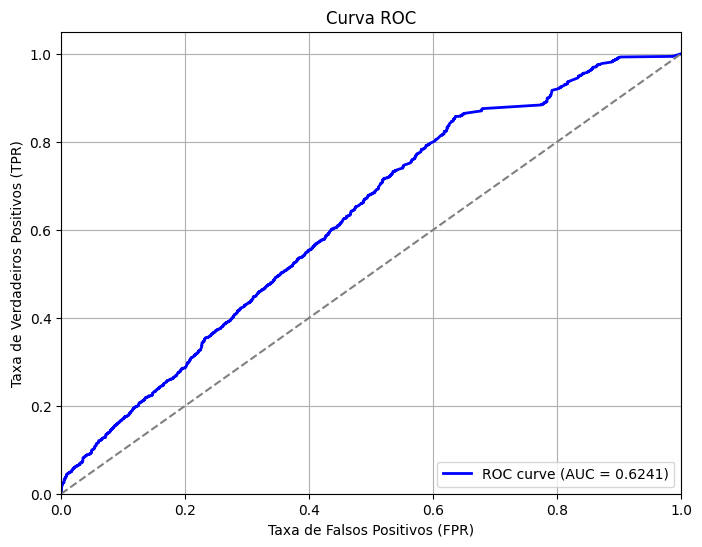

In [32]:
plot_roc_curve(y_true, y_pred_probs)